In [53]:
import json
import numpy as np
from preprocess_data.process_ground_truth import reform_ground_truth, ground_truth_sep
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from hyperopt import hp, fmin, tpe, Trials
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.utils import to_categorical

In [26]:

with open('/Users/ruotsing/PycharmProjects/DMS/preprocess_data/lateral_acceleration_data.json', 'r') as f:
    LA_data = json.load(f)
    
    
with open('/Users/ruotsing/PycharmProjects/DMS/preprocess_data/SWA_data.json', 'r') as f:
    SWA_data = json.load(f)

with open('/Users/ruotsing/PycharmProjects/DMS/preprocess_data/lateral_displacement_data.json', 'r') as f:
    LD_data = json.load(f)
    
with open('/Users/ruotsing/PycharmProjects/DMS/preprocess_data/YA_data.json', 'r') as f:
    YA_data = json.load(f)
    
with open('/Users/ruotsing/PycharmProjects/DMS/preprocess_data/ground_truth.json', 'r') as f:
    ground_truth = json.load(f)
    
def time_derivative(data, time_interval):
    data_dt = {}
    for name in data.keys():
        delta_displacement = np.diff(data[name])
        data_dt[name] = np.gradient(delta_displacement, time_interval)
    return data_dt

sample_rate = 100
SWV_data= time_derivative(SWA_data, 1/sample_rate)
YR_data= time_derivative(YA_data, 1/sample_rate)

#standardize the data
def standardize(data):
    data_standard = {}
    for name in data.keys():
        data_standard[name] = (data[name] - np.mean(data[name]))/np.std(data[name])
    return data_standard

YR_standard = standardize(YR_data)
SWA_standard = standardize(SWA_data)
SWV_standard = standardize(SWV_data)
LD_standard = standardize(LD_data)
LA_standard = standardize(LA_data)

#apply the time window
size_= 10
step = 1
ground_truth=reform_ground_truth(ground_truth)
awake_window, _, drowsy_window=ground_truth_sep(ground_truth,size_,step) #ignoew the light drowsy state

def define_feature_matrix(window, data):
    feature_matrix = []
    for name in window.keys():
        for i in range(len(window[name])):
            begin = window[name][i][0]*sample_rate
            end = (window[name][i][-1]+1)*sample_rate
            feature_matrix.append(data[name][begin:end])
    return np.array(feature_matrix)
    

awake_YR_feature = define_feature_matrix(awake_window, YR_standard)
awake_SWA_feature = define_feature_matrix(awake_window, SWA_standard)
awake_SWV_feature = define_feature_matrix(awake_window, SWV_standard)
awake_LD_feature = define_feature_matrix(awake_window, LD_standard)
awake_LA_feature = define_feature_matrix(awake_window, LA_standard)
awake_feature_matrix=np.dstack((awake_YR_feature, awake_SWA_feature, awake_SWV_feature, awake_LD_feature, awake_LA_feature))
awake_label = np.ones(awake_feature_matrix.shape[0])*0

drowsy_YR_feature = define_feature_matrix(drowsy_window, YR_standard)
drowsy_SWA_feature = define_feature_matrix(drowsy_window, SWA_standard)
drowsy_SWV_feature = define_feature_matrix(drowsy_window, SWV_standard)
drowsy_LD_feature = define_feature_matrix(drowsy_window, LD_standard)
drowsy_LA_feature = define_feature_matrix(drowsy_window, LA_standard)
drowsy_feature_matrix=np.dstack((drowsy_YR_feature, drowsy_SWA_feature, drowsy_SWV_feature, drowsy_LD_feature, drowsy_LA_feature))
drowsy_label=np.ones(drowsy_feature_matrix.shape[0])


feature_matrix=np.concatenate((awake_feature_matrix, drowsy_feature_matrix), axis=0)
label=np.concatenate((awake_label, drowsy_label), axis=0)
label=label.astype(int)

In [42]:

X_train, X_test, y_train, y_test = train_test_split(feature_matrix, label, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


In [47]:

def make_model(space,best_params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        # filters, kernel_size, activation, input_shape
        tf.keras.layers.Conv1D(space['conv_filters_1'][best_params['conv_filters_1']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        # window size
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_2'][best_params['conv_filters_2']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_3'][best_params['conv_filters_3']], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.Conv1D(space['conv_filters_4'][best_params['conv_filters_4']], 3, activation=None, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(space['pooling_size_hyperopt'][best_params['pooling_size_hyperopt']]),
        
        tf.keras.layers.LSTM(space['neurons_lstm'][best_params['neurons_lstm']]),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=space['learning_rate'][best_params['learning_rate']]), loss=tf.keras.losses.CategoricalFocalCrossentropy(), metrics=[Recall(),Precision(),AUC()]) #maybe change the loss function
    return model

In [60]:

def confusion_matrix_on_test_data(model,model_name, X_test, y_test):
    y_pred=[]
    for row in model.predict(X_test):
        y_pred.append(np.argmax(row))
    y_pred=np.array(y_pred) 
    cm = confusion_matrix(y_test, y_pred)
    print('Recall:', recall_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))
    print('Precision:', cm[1,1]/(cm[1,1]+cm[0,1]))
    plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Awake', 'Drowsy'], yticklabels=['Awake', 'Drowsy'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix of '+model_name)
    plt.show()
    

In [30]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / len(awake_label)) * (len(label) / 2.0) #awake
weight_for_1 = (1 / len(drowsy_label)) * (len(label) / 2.0) #drowsy

class_weight = {0: weight_for_0, 1: weight_for_1}

In [31]:
space = {
    'conv_filters_1': hp.choice('conv_filters_1', [32, 64, 128]),
    'conv_filters_2': hp.choice('conv_filters_2', [32, 64, 128]),
    'conv_filters_3': hp.choice('conv_filters_3', [32, 64, 128]),
    'conv_filters_4': hp.choice('conv_filters_4', [32, 64, 128]),
    'mini_batch_size': hp.choice('mini_batch_size', [32, 64, 128]),
    'learning_rate': hp.choice('learning_rate', [0.001, 0.005, 0.01]),
    'pooling_size_hyperopt': hp.choice('pooling_size_hyperopt', [2,3]),
    'neurons_lstm': hp.choice('neurons_lstm', [32, 64, 128]),
    'neurons_gru': hp.choice('neurons_gru', [32, 64, 128])
}

space_params = {
    'conv_filters_1': [32, 64, 128],
    'conv_filters_2': [32, 64, 128],
    'conv_filters_3': [32, 64, 128],
    'conv_filters_4': [32, 64, 128],
    'learning_rate': [0.001, 0.005, 0.01],
    'mini_batch_size': [32, 64, 128],
    'pooling_size_hyperopt': [2,3],
    'neurons_lstm': [32, 64, 128],
    'neurons_gru': [32, 64, 128]
}

In [ ]:
def objective_weighted(params):
    Input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    model= tf.keras.models.Sequential([
        Input_layer,
        tf.keras.layers.Conv1D(params['conv_filters_1'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_2'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_3'], 3, activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.Conv1D(params['conv_filters_4'], 3, activation=None, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling1D(params['pooling_size_hyperopt']),
        
        tf.keras.layers.LSTM(params['neurons_lstm']),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2, activation='softmax')
        # tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss=tf.keras.losses.CategoricalFocalCrossentropy(), metrics=[Recall(),Precision(),AUC()])
    model.fit(X_train, y_train, epochs=5, batch_size=params['mini_batch_size'], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)
    f1=f1_score(y_val.argmax(axis=1), model.predict(X_val).argmax(axis=1))
    return -f1  # Hyperopt minimizes the objective function

trials = Trials()
best_params_weighted = fmin(objective_weighted, space, algo=tpe.suggest, max_evals=30, trials=trials)

print("Best hyperparameters:", best_params_weighted)

best_weighted_model = make_model(space_params, best_params_weighted)
best_weighted_model.fit(X_train, y_train, epochs=5, batch_size=space_params['mini_batch_size'][best_params_weighted['mini_batch_size']], validation_data=(X_val, y_val), verbose=0, class_weight=class_weight)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Recall: 0.8571428571428571
F1: 0.16687737041719342
Precision: 0.09243697478991597


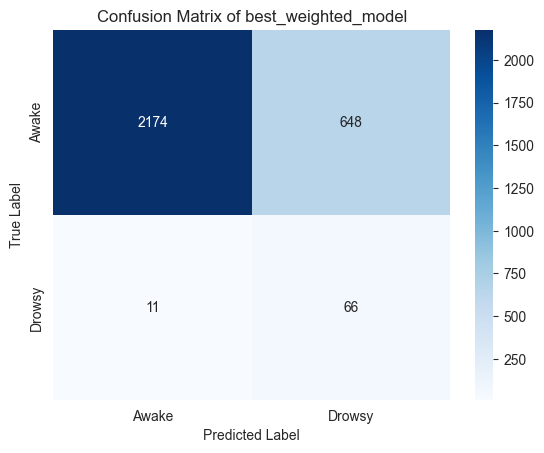

In [61]:

confusion_matrix_on_test_data(best_weighted_model, 'best_weighted_model', X_test, y_test)